## Loading/preparing data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)

STLdata = pd.read_csv(r'C:\Users\maria\OneDrive\Documents\RESEARCH\Data files\ruralurban_driving summary.csv')

# converts the overall rural/urban code to a dummies 'Rural' variable usable by machine learning models 
# (0 = urban, 1 = rural) and drops old coding and uid columns

STLdata = pd.concat((STLdata, pd.get_dummies(STLdata["overall RU code"])), axis=1)
STLdata = STLdata.drop(columns = ["RUCA_ru", "other_ru", "overall RU code", "Urban", "uid"])

## Preliminary feature selection

At this point, we will reduce mulicollinearity (predictor variables being significantly correlated with each other, rather than just with the target variable) within the feature set by (1) using the abritrary boundary of linear correlation <= 0.2 between features and (2) using filter and "feature importance" FS methods to choose which features within a collinear group are most important to keep. 

This step is important because the more complex FS methods that we will later use would be skewed by the presence of correlated features (e.g. recursive/sequential FS removes the least important and/or adds the most important feature at each step by fitting and testing the model; since correlated features are usually weighted with similar importances, they will be kept or removed together, but will together negatively affect model performance). In addition, while the prediction accuracy of RF models may be unaffected by collinear variables, our alternate models may be. Overall, we will remove collinear variables to (1) make the models more interpretable and computationally easier to handle, (2) increase speed and accuracy of wrapper FS methods, and (3) ensure multiplecollinearity does not negatively impact some ML models.

In [2]:
## creating train_test splits and initialized random forest model as needed for some methods in this section

## NOTE: We will be using the entire dataset here, despite some possibility of information leak, simply because the
## dataset being analyzed is not large enough (mainly, does not have enough rural participants) to allow for creation
## of a third split of data to be kept solely for testing; while typically feature selection could be performed on the train split
## only, this is more difficult to carry out when cross-validation is used for testing the models (there is no "one" train
## and test split, so one FS method would need to be chosen and integrated into the pipeline, which may pose some challenges).

## NOTE: Although 3/4 of the target models involved oversampling to artifically 'balance' the data (SMOTE-rf, SMOTE-lr, and 
# SMOTE-XGBoost), literature indicates that oversampling should NOT be done before feature selection, since "most variable 
# selection methods assume that the samples are independent" (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3648438/); instead, 
# for wrapper/embedded FS methods, I will use a balanced version of the standard random forest model. This should hopefully 
# allow feature selection to be catered towards the RF model as desired, while the balanced parameter should reduce error 
# that may occur due to bias towards the majority (urban) class in the model. The use of a simple model also allows us to test 
# various feature selection methods (whereas if SMOTE was included, one FS method would need to be chosen & integrated into a pipeline).

from sklearn.ensemble import RandomForestClassifier

X = STLdata.iloc[:, :-1]
y = STLdata["Rural"]

rf = RandomForestClassifier(class_weight = 'balanced', n_estimators = 150, random_state = 112)

### Correlation/ confusion matrix (filter)

<AxesSubplot:>

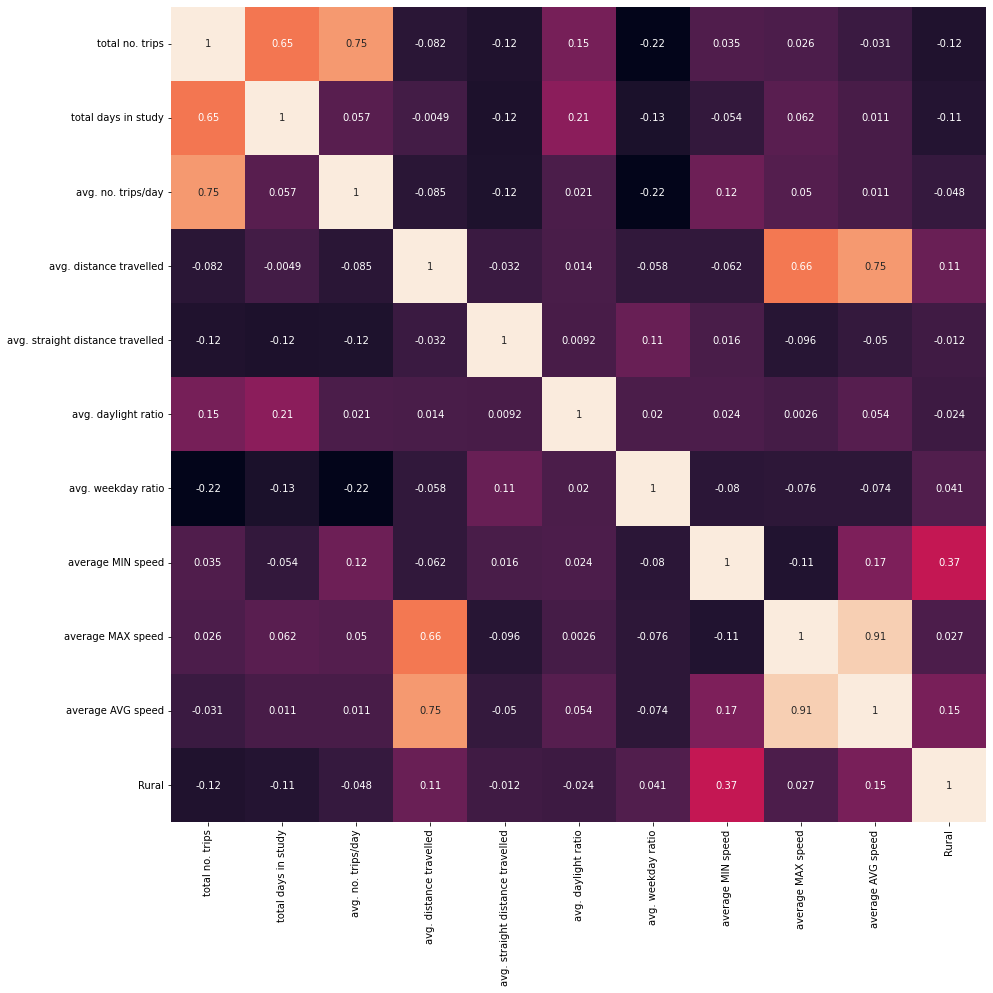

In [3]:
## simply computes the linear correlation between every two variables in the provided dataset, 
## where 0 = no correlation (completely independent) and 1 = full linear correlation (completely dependent)

plt.figure(figsize = (20, 15))
sns.heatmap(pd.concat([X.iloc[:, :10], y], axis = 1).corr(), annot = True, cbar = False, square = True)

# iloc is used to visualize desired sections of the matrix, since there are too many features right now to visualize the entire set clearly

### Information gain (filter)

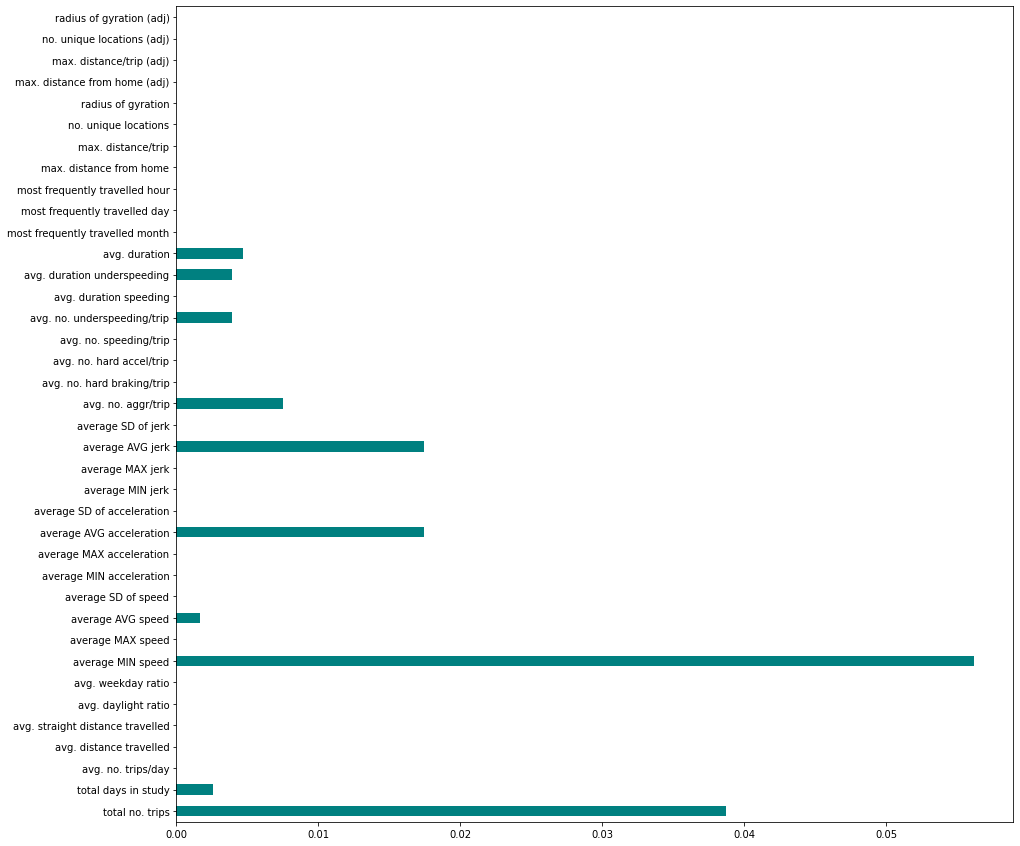

In [4]:
from sklearn.feature_selection import mutual_info_classif

plt.figure(figsize = (15, 15))

## computes the 'mutual information' or dependency between each feature and the target, and plots this for each feature
importances = pd.Series(mutual_info_classif(X, y), STLdata.columns[:-1])
importances.plot(kind = 'barh', color = 'teal')

plt.show()

### F-score (filter)

In [5]:
from sklearn.feature_selection import SelectKBest, f_classif

## selector computes ANOVA f-statistic and corresponding p-values, and the features are displayed in descending order of
## significance (essentially, features are more significant when there is more difference between the classes for that feature)

selector = SelectKBest(f_classif, k = 'all').fit(X, y)
scores = -np.log10(selector.pvalues_) ## makes for more interpretable scores, since smaller p-value = better score

d = {X.columns[i]: scores[i] for i in range(len(scores))} # creates dictionary
d = sorted(d.items(), key = lambda x: x[1], reverse = True) # sorts it in descending order for values

for i in range(0, len(d), 2):
    print(f"{d[i][0]}: {d[i][1]}")
        
# average MIN speed, average AVG speed/acceleration/jerk, most frequently travelled month, most frequently travelled day,
# avg. distance travelled, avg. duration speeding

average MIN speed: 8.60786786170836
average AVG acceleration: 2.307084687017363
total no. trips: 1.1698517774442083
avg. distance travelled: 1.0847058414640867
most frequently travelled month: 0.9491065276280907
average SD of speed: 0.6058592129881041
avg. no. hard braking/trip: 0.36557724960121973
avg. duration speeding: 0.3612456285302091
avg. no. underspeeding/trip: 0.3404053659066587
avg. no. trips/day: 0.3396561673822794
max. distance from home: 0.2226213177649668
average MAX speed: 0.1747972592984844
average MIN acceleration: 0.16387245295432534
average SD of jerk: 0.12582087654190452
no. unique locations: 0.11695562719694247
max. distance/trip (adj): 0.09232399552364458
max. distance from home (adj): 0.0711092733903448
radius of gyration (adj): 0.035142071631971035
average MAX acceleration: 0.032215356900548164


### RF importances (embedded)

In [6]:
### random forest importances (as part of the sklearn random forest class itself) are computed based on how much a feature
### increases purity at a node within the decision trees; note that RF ranks correlated features at similar importance

from sklearn.feature_selection import SelectFromModel

rf.fit(X, y) ## note that while we can re-use the same random forest model initially created, it is important
            ## that the fit model is not used for feature selection methods that use un-fit models
            ## otherwise results may be inaccurate or lead to overfitting (hence why these methods are placed last)

importances_df = pd.DataFrame({"Features": X.columns, "Importances": rf.feature_importances_})
importances_df.sort_values(by = "Importances", ascending = False, inplace = True)
display(importances_df.head(20))

,Features,Importances
7,average MIN speed,0.231578
1,total days in study,0.060446
13,average AVG acceleration,0.059441
17,average AVG jerk,0.048246
4,avg. straight distance travelled,0.045444
0,total no. trips,0.038305
23,avg. no. underspeeding/trip,0.033314
3,avg. distance travelled,0.032537
30,max. distance from home,0.025840
22,avg. no. speeding/trip,0.025473


### SHAP importances (wrapper)

c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


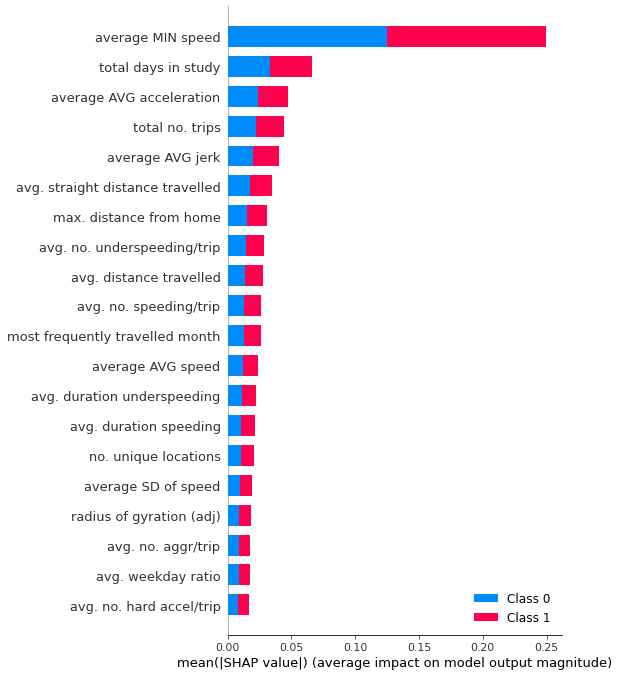

In [7]:
import shap

rf.fit(X, y)

## computes SHAP interaction values, which essentially represent how much a feature contributes to the model's prediction
shap.initjs()
shap.summary_plot(shap.TreeExplainer(rf).shap_values(X), features = X, feature_names = X.columns)

### Conclusions

Highly correlated features include (* = feature chosen for higher correlation with class OR, if correlations are similar, for higher importance in preliminary feature selection/rankings):

- (1a-d) skmob features & their adjusted counterparts --> radius of gyration (adj)*, the rest non-adj
- (2) max. distance from home* & max. distance/trip
- (3) avg. duration, avg. duration speeding*, avg. duration underspeeding*
- (4) avg. no hard braking/trip, avg. no hard accel/trip, avg. no aggr/trip*
- (5) avg. duration/no.* underspeeding and avg. duration/no.* speeding
- (6) total no. trips, avg. no. trips/day, total days in study*
- (7) average MAX, AVG, and SD of speed; avg. distance travelled*; and average MIN acceleration
- (8) avg. distance travelled*, average AVG speed*, average MAX acceleration, average SD of acceleration
- (9) average AVG*, MAX, MIN, SD of jerk
- (10) average AVG acceleration, AVG jerk, and MIN speed*
- (11) avg. duration speeding/underspeeding & avg. distance travelled*
- (12) most frequently travelled hour & avg. daylight ratio*
- (13) total days in study* & no. unique locations (adj) & radius of gyration (adj)
- (14) most frequently travelled day & weekday ratio*
- (15) avg. daylight ratio & total days in study*

For groups of correlated features where all features were ultimately removed (due to correlation of chosen variables within other groups), check if there are any earlier-removed features of similar importances that could be kept in (e.g. that have a linear correlation <= 0.2 in the confusion matrix) by placing them back into the confusion matrix:

- (1b) max. distance/trip (adj)? --> no, still correlated with max. distance from home
- (1c) no. unique locations? --> no, still highly correlated with total days in study
- (1d) radius of gyration? --> no, still highly correlated with max. distance from home & max. distance/trip
- (3) avg. duration? --> no, extremely correlated with avg. distance travelled
- (5) avg. no. speeding/underspeeding? --> no, either has significant multiple collinearity e.g. with avg. distance travelled
- (9) average MAX, MIN, or SD of jerk? --> no, any of these has significant multicollinearity in the matrix
- (12) most frequently travelled hour? --> yes, while this feature may be slightly less prevalent than daylight ratio, it can be kept in as it presents very little multicollinearity within the matrix!

In [8]:
## removing confounding variables, or variables that are correlated with each other

X = X.drop(columns = ["max. distance from home (adj)", "max. distance/trip (adj)", "no. unique locations", 
                                  "radius of gyration", "max. distance/trip", "avg. duration",
                                  "avg. no. hard braking/trip", "avg. no. hard accel/trip", "avg. no. speeding/trip",
                                  "avg. no. underspeeding/trip", "total no. trips", "avg. no. trips/day",
                                  "average MAX speed", "average SD of speed", "average MIN acceleration",
                                  "average MAX acceleration", "average SD of acceleration", "average MIN jerk",
                                  "average MAX jerk", "average SD of jerk", "average AVG acceleration", "average AVG jerk",
                                  "average AVG speed", "avg. duration speeding", "avg. duration underspeeding", 
                                  "radius of gyration (adj)", "no. unique locations (adj)",
                                  "most frequently travelled day", "avg. daylight ratio"])

## Ultimate feature selection

Now that significant multiplecollinearity was eliminated from the dataset features (9 features remaining), we can use wrapper methods to choose the final feature set for our ML models.

For these methods, roc_auc (area under the Receiver Operating Curve) is chosen as the scoring metric as it is proportional to the mean of recall and specificity. This means it captures the accuracy of the model in identifiying both urban and rural participants - in contrast to the f1 score, which focuses on rural participants only.

In [10]:
## initializing new, unfit version of random forest model

rf = RandomForestClassifier(class_weight = 'balanced', n_estimators = 150, random_state = 112)

In [11]:
from sklearn.model_selection import RepeatedStratifiedKFold ## will be used in all cases except exhaustive
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector as SFS_scikit
from mlxtend.feature_selection import SequentialFeatureSelector as SFS_mlx ## this version allows selection of best no. features

CV = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5, random_state = 112) ## 4 splits of dataset = 2 rural instances in each fold

### recursive FS

NOTE: While sklearn recursive FS normally uses feature importances as test metric, this version includes both cross-validation as well as the ability to use a different scoring metric, which should make it more prevalent than the feature importances version.


In [23]:
from sklearn.feature_selection import RFECV 

featureselector = RFECV(rf, cv = CV, scoring = 'roc_auc')
featureselector.fit(X, y)  # fit after, not before, for sequential or recursive feature selection

print(f"Optimal number of features: {featureselector.n_features_}")

X_new = X.loc[:, featureselector.get_support()]
print(X_new.columns)

Optimal number of features: 8
Index(['total days in study', 'avg. distance travelled',
       'avg. straight distance travelled', 'avg. weekday ratio',
       'average MIN speed', 'avg. no. aggr/trip',
       'most frequently travelled month', 'max. distance from home'],
      dtype='object')


### sequential FS (mlxtend)

In [12]:
### FORWARDS

SFS = SFS_mlx(rf, k_features = 'best', forward = True,  n_jobs = -1, scoring = 'roc_auc', cv = CV)
SFS.fit(X, y)

print(list(SFS.k_feature_names_))

['average MIN speed', 'max. distance from home']


In [14]:
### BACKWARDS

SFS = SFS_mlx(rf, k_features = 'best', forward = False,  n_jobs = -1, scoring = 'roc_auc', cv = CV)
SFS.fit(X, y)

print(list(SFS.k_feature_names_))

['total days in study', 'avg. distance travelled', 'average MIN speed', 'most frequently travelled month']


### sequential FS (SciKitLearn)

In [17]:
### FORWARD

sfs = SFS_scikit(rf, direction = "forward", cv = CV, scoring = "roc_auc", n_features_to_select = "auto", tol = 0.001)
sfs.fit(X, y)           ## features will be added/removed until score is constant within a range of 0.001

X_new = X.loc[:, sfs.get_support()]
print(X_new.columns)

Index(['average MIN speed', 'most frequently travelled month',
       'max. distance from home'],
      dtype='object')


In [15]:
### BACKWARD

sfs = SFS_scikit(rf, direction = "backward", cv = CV, scoring = "roc_auc", n_features_to_select = "auto", tol = 0.001)
sfs.fit(X, y)           ## features will be added/removed until score is constant within a range of 0.001

X_new = X.loc[:, sfs.get_support()]
print(X_new.columns)

Index(['total days in study', 'avg. distance travelled', 'avg. weekday ratio',
       'average MIN speed', 'most frequently travelled month',
       'most frequently travelled hour'],
      dtype='object')


NOTE: The above feature sets change slightly as the cells are re-run; this is likely due to varying shuffling of the feature sets that occur before recursive or sequential selection.

### exhaustive FS

In [60]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector

efs = ExhaustiveFeatureSelector(rf, min_features = 3, max_features = 9, print_progress = True, scoring = 'roc_auc', 
cv = StratifiedKFold(n_splits = 4)) ## using a non-repeated CV here since this method is already very computationally heavy

efs = efs.fit(X, y)

best_features = X.columns[list(efs.best_idx_)]
print(best_features)

Features: 466/466

Index(['total days in study', 'avg. distance travelled', 'avg. weekday ratio',
       'average MIN speed'],
      dtype='object')


### Choosing final features

Out of these feature selection methods, the exhaustive feature selection should give the absolute best set of features since it iteratively tests all possible sets. However, in the process of creating this notebook and for learning purposes, five different feature sets were tested, corresponding to the four FS methods that generated sets with at least 4 features (recursive, fwd mlxtend SFS, bckwd scikit SFS, exhaustive), as well as one set that included all except the least-commonly-chosen features ('most frequently travelled hour' and 'avg. no. aggr/trip'). However, the exhaustive feature set still provided the best scores across all models, so we will use this feature set in our final feature selection.

In [20]:
X = X.filter(items = ["total days in study", "avg. distance travelled", "avg. weekday ratio", "average MIN speed"]) ## feature set corresponding to exhaustive FS

## NOTE: While certain features (such as 'avg. no. aggr/trip') seemed to have value in discriminating between rural and urban individuals based on the correlation plots,
## these features likely had too much collinearity with other, more important, variables, and thus acted to decrease model performance rather than positively contribute to it.

# Also, the four remaining features all present objectively different information: time (days) that a participant remained in the study for, average distance that a participant 
# travelled per trip, average ratio of how many weekdays to weekends that a participant drove, and the average minimum speed recorded for a participant.

<AxesSubplot:>

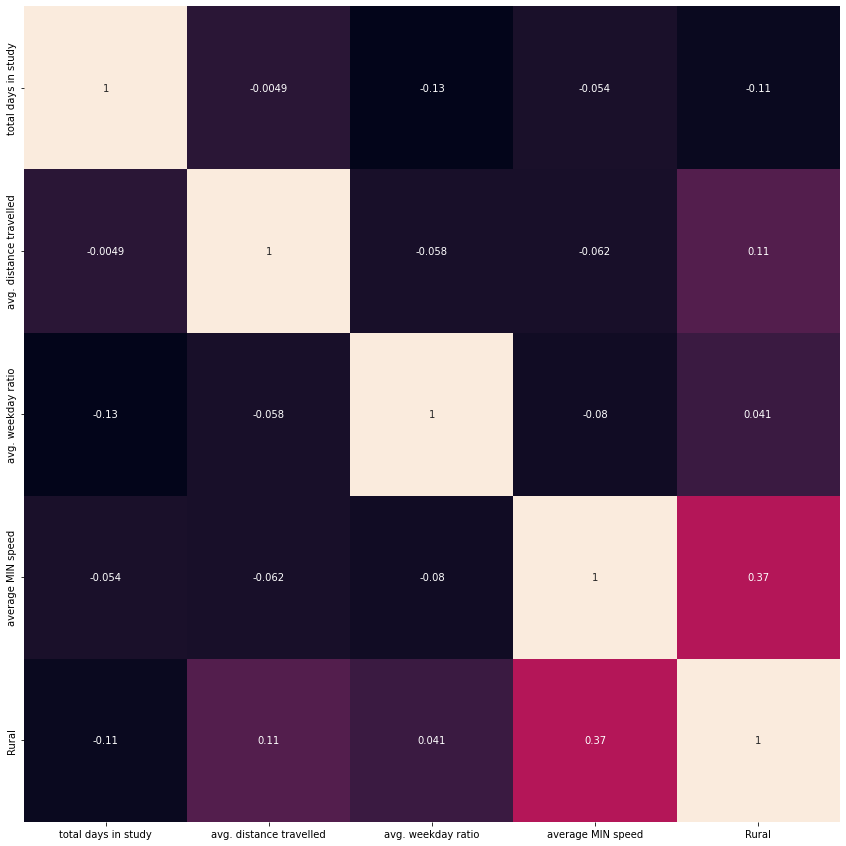

In [21]:
## Replotting the correlation/confusion matrix to visualize our final feature set: the final feature selection (4 features) show some collinearity, but 
## all with linear coefficients <= 0.13, which we will assume to be sufficiently small for the sakes of this project.

plt.figure(figsize = (20, 15))
sns.heatmap(pd.concat([X, y], axis = 1).corr(), annot = True, cbar = False, square = True)

## Data Preprocessing (feature transformation & data oversampling)

Now that we have the set of features that will be used in the machine learning models, one further preprocessing step should be considered: data scaling/transformation. Since the values for different features may exist in different ranges, they may be weighted differently by the machine learning models, leading to inaccuracies. While this generally does not pose a problem for random forest models, since we are developing four different models, we will perform preprocessing on the data before modelling to allow comparability. 

For this step, we will apply standardization (transforms feature values to their z-score, aka makes each feature value relative to the mean and standard deviation of all observations for that feature). This method is chosen above normalization due to its ability to be used with outliers (which may be present in some cases in this data, based on boxplots created in the previous task). Note this method is considered to work better with normal feature distributions, which is not a reasonable assumption for many of the given features (based on box, violin, and histplots created in the previous task). However, standardization is generally considered to give rise to better predictions in machine learning models.

The final preprocessing step is oversampling, which is a method used to combat class imbalance (here, we have high class imbalance with only 3% of the dataset pertaining to rural individuals, and the other 97% to urban) since class imbalance often leads to models that predict only the majority class in order to maximize accuracy. SMOTE performs oversampling by creating synthetic data points for the minority (rural) class, using neighbouring data points to create synthetic points 'in between'. Literature suggests that this technique leads to better results than standard oversampling (making copies of random data points within the minority class until the classes have equal number of data points) or undersampling (removing random data points within the majority class until the classes have equal number of data points).

Both StandardScaler and SMOTE will be implemented during the model creation and evaluation process (in a pipeline), to prevent information leak between test and training sets that could occur if these preprocessing steps were performed on the entire dataset BEFORE splitting.

In [23]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

## Model Creation + Evaluation

In [24]:
def print_scores (model, CV = 2, cv_score = 'all', smote = False):
    '''
    This function prints certain test metrics (e.g. accuracy, area under the receiver-operating-curve, precision, etc) for 
    a machine learning model on cross-validated training and test splits of a dataset. Required global variables are X and y.
    
    Arguments required are:
    model = The machine learning model to be evaluated (initialized but not yet fit; it will be automatically fit to the train 
    split of the data for each cross-validation fold/iteration).
    cv = Either the number of folds desired for stratified k-fold cross-validation, or the desired cross-validator itself.
    Note that this cross-validator will be used for all metrics except accuracy (which will automatically use LeaveOneOut).
    cv_score = The type of cross-validation score desired, e.g. 'precision and recall' or 'f'.
    smote = Whether or not the model uses SMOTE; if True, an oversampling step will be included in the pipeline.
    
    '''    

    ### whether or not to use SMOTE oversampling in the model
    
    # Note the use of a pipeline here b/c oversampling should NOT be done on the entire dataset otherwise information
    # may leak between the training and test set, leading to scores that do not accurately represent model performance
    # (e.g. indicate the model is better than it actually is); the pipeline works by splitting the entire X/y set into
    # training and test splits for each cross-validation iteration, and then only oversampling the training set while 
    # testing on actual data
    
    # Also, caution must be taken when choosing the CV split due to the low number of rural individuals in the test 
    # set which may lead to some errors in calculating metrics (e.g. 4-fold CV = only 2 rural individuals in test set,
    # although there should be many more in the training set if oversampling is performed).
    
    if smote is True:
        pipe = Pipeline(steps = [['scaler', StandardScaler()], 
                                 ['oversampler', SMOTE(random_state = 112)],
                                 ['classifier', model]])
    elif smote is False:
        pipe = Pipeline(steps = [['scaler', StandardScaler()],
                                 ['classifier', model]])
    

    ### converts the inputted 'cv_score' string into useable information about the desired metrics

    if cv_score == 'all':
        cv_score = 'roc_auc, precision, recall, accuracy, balanced_accuracy'

    scoring = []
    if 'roc_auc' in cv_score:
        scoring.append('roc_auc')
    if 'precision' in cv_score:
        scoring.append('precision')
    if 'recall' in cv_score:
        scoring.append('recall')
    if 'f' in cv_score:
        scoring.append('f1')
    if 'balanced' in cv_score:
        scoring.append('balanced_accuracy')


    ### computes scores; for each metric, appends a list with metric name and test/train (CV) scores to empty list
    ### and returns this list as a formatted dataframe of scores

    scores = cross_validate(pipe, X, y, scoring = tuple(scoring), cv = CV, return_train_score = True)
    CV_scores = []

    if 'accuracy' in cv_score:
        acc_score = cross_validate(pipe, X, y, scoring = 'accuracy', cv = LeaveOneOut(), return_train_score = True)
        CV_scores.append(['accuracy', mean(acc_score["train_score"]), stdev(acc_score["train_score"]), mean(acc_score["test_score"]), stdev(acc_score["test_score"])])

    for item in scoring:    
        CV_scores.append([f"{item}", mean(scores[f"train_{item}"]), stdev(scores[f"train_{item}"]), mean(scores[f"test_{item}"]), stdev(scores[f"test_{item}"])])

    CV_scores = pd.DataFrame(CV_scores, columns = ['', 'train', 'std (train)', 'test', 'std (test)'])
    CV_scores.set_index('', inplace = True)

    print('\033[1m' + f"Cross-Validation Scores using {model}" + '\033[0m')
    display(CV_scores)

In [25]:
def RUconfusion (model, smote = False):
    '''
    This function plots a rural-urban confusion matrix given a datset. In other words, it compares the true class of each
    individual in the test set (y_test), as determined by their home locations and corresponding rural-urban codes, to their
    classes predicted by the chosen machine learning model (model.predict(X_test)). The model passed into the function 
    should already be parameterized, but does need to be fit.
    '''

    ### creating train and test splits from X and y;
    ## while not using a pipeline here (not necessary since no CV), notice that the train_test_split is done first & then
    ## the train and test sets are oversampled seperately, once again so that information leak does not occur between the set

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 112)

    X_train._index(drop = True, inplace = True) ## resetting indices of all sets, since mixed indices may
    X_test.reset_index(drop = True, inplace = True)   ## negatively impact the model in some cases
    y_train.reset_index(drop = True, inplace = True)
    y_test.reset_index(drop = True, inplace = True)
    
    ### performing feature transformation (preprocessing)
    X_train = pd.DataFrame(s.fit_transform(X_train), columns = X_train.columns) # transforming the values for each feature in train based on the mean/std of that feature
    X_test = pd.DataFrame(s.fit_transform(X_test), columns = X_test.columns)    ## while best practice is apparently to standardize test features based on mean/std in train,
                                                                                ### the pipeline does not seem to do so, so we will reflect this in the confusion matrix
    
    ### performing oversampling (if smote = True) and fitting the model
    if smote is False:
        model.fit(X_train, y_train)
        
    elif smote is True:
        X_train_over, y_train_over = SMOTE(random_state = 112).fit_resample(X_train, y_train)
        X_train_over.reset_index(drop = True, inplace = True) ## resetting indices of both sets, since mixed indices may
        y_train_over.reset_index(drop = True, inplace = True)  ## negatively impact the model in some cases
    
        model.fit(X_train_over, y_train_over)
        
    ### creating confusion matrix for model   
 
    confusion = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(confusion, square = True, annot = True, cbar = False, cmap = 'icefire', 
                xticklabels = ['urban', 'rural'], yticklabels = ['urban', 'rural'])

    plt.xlabel('predicted value')
    plt.ylabel('true value')

In [26]:
def print_roc (model, CV = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 112), smote = False):
    '''
    This function plots a Receiver Operating Characteristic (ROC) curve based on the cross-validated probability of being the positive (rural) class for each instance. Note that the
    ROC curve is plotted manually as y = true positive rate and x = false negative rate, rather than using the sklearn function, so that cross-validation can be used.
    '''
    
    if smote is True:
        pipe = Pipeline(steps = [['scaler', StandardScaler()], 
                                 ['oversampler', SMOTE(random_state = 112)],
                                 ['classifier', model]])
    elif smote is False:
        pipe = Pipeline(steps = [['scaler', StandardScaler()],
                                 ['classifier', model]])

    y_probabilities = cross_val_predict(pipe, X, y, cv = CV, method = 'predict_proba') ## returns the probabilities of each instance being urban (column 0) or rural (column 1)

    fpr, tpr, thresholds = roc_curve(y, y_probabilities[:, 1]) ## returns list of false positive rates, true positive rates, and corresponding thresholds
    roc_auc = auc(fpr, tpr)
    best_threshold = thresholds[np.argmax(tpr - fpr)]  ## finds index of fpr/trp/threshold group with best Youden's J statistic,
                                                      ## as the 'optimal' balance between sensitivity and specificity (g-mean)

    plt.plot(fpr, tpr, label = f'ROC curve (area = {round(roc_auc, 5)}, threshold = {round(best_threshold, 5)})')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Curve')
    plt.legend(loc="lower right")
    plt.show()


In [27]:
from statistics import mean
from statistics import stdev

from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

For each model, grid search will first be performed to find the best models hyperparameters, and then data preprocessing and model scoring will occur together in a pipeline. Note the pipeline is used for both hyperparameter tuning and model creation, for consistency as well as to prevent excess information leak, as previously discussed.

### Logistic regression (with SMOTE)

In [29]:
### grid search initializers

from sklearn.linear_model import LogisticRegression

CV = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 112)

In [30]:
# Preliminary grid search (searches 5x9x5 = 225 sets of random values)

pipeline = Pipeline(steps = [['scaler', StandardScaler()], 
                             ['oversampler', SMOTE(random_state = 112)],
                             ['classifier', LogisticRegression(random_state = 112)]])

grid = {'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], ## note 'classifier__' needed to specify the element in the pipeline which we are investigating
        'classifier__max_iter': list(np.arange(50, 501, 50)),
        'classifier__C': [0.1, 1, 10, 100, 1000]}

prelim_grid_search = GridSearchCV(estimator = pipeline, param_grid = grid, scoring = 'roc_auc', cv = CV, n_jobs = -1)
prelim_grid_search.fit(X, y)

prelim_grid_search.best_params_

{'classifier__C': 0.1,
 'classifier__max_iter': 50,
 'classifier__solver': 'newton-cg'}

In [33]:
# Final grid search (searches 12x2x10 = 240 sets of random values)

pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['oversampler', SMOTE(random_state = 112)],
                             ['classifier', LogisticRegression(solver = 'newton-cg', random_state = 112)]])

grid = {'classifier__max_iter': list(np.arange(15, 76, 5)), # while grid search seems to favour very low no. iterations, this often results in the solver not converging, so we will set the minimum at 15
        'classifier__penalty': ['none', 'l2'],  ## only two penalties supported by newton-cg
        'classifier__C': list(np.arange(0.1, 1.1, 0.1))}

prelim_grid_search = GridSearchCV(estimator = pipeline, param_grid = grid, scoring = 'roc_auc', cv = CV, n_jobs = -1)
prelim_grid_search.fit(X, y) ## try with oversampled data to prevent k_neighbors problem in pipeline?

prelim_grid_search.best_params_

Setting penalty='none' will ignore the C and l1_ratio parameters


{'classifier__C': 0.1,
 'classifier__max_iter': 15,
 'classifier__penalty': 'none'}

The final, best parameters for a SMOTE-lr model were determined to be:
- 'classifier__solver': 'newton-cg'
- 'classifier__C': 0.1                (only used if penalty is not 'none', so can be disregarded)
- 'classifier__max_iter': 15
- 'classifier__penalty': 'none'

Cross-Validation Scores using LogisticRegression(max_iter=15, penalty='none', random_state=112,
                   solver='newton-cg')


,train,std (train),test,std (test)
,,,,
accuracy,0.935075,0.002485,0.922764,0.267509
roc_auc,0.976145,0.007201,0.962677,0.034926
precision,0.346219,0.053411,0.275655,0.134428
recall,1.000000,0.000000,0.800000,0.299122
balanced_accuracy,0.967234,0.007133,0.861801,0.144758


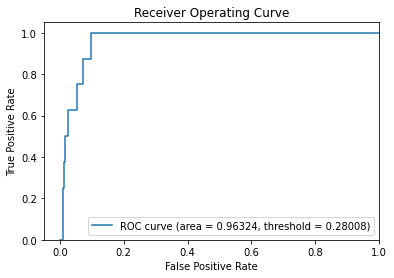

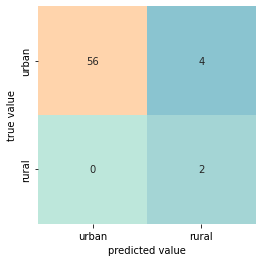

In [34]:
SMOTE_lr = LogisticRegression(solver = 'newton-cg', penalty = 'none', max_iter = 15, random_state = 112) # note that C is not included since it only makes sense for penalty != 'none'

print_scores(SMOTE_lr, CV = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5, random_state = 112), cv_score = 'all', smote = True)
print_roc(SMOTE_lr, smote = True)
RUconfusion(SMOTE_lr, smote = True)

## NOTE: optimizing for precision in the grid search (instead of roc_auc) increases precision only slightly (e.g. by 0.01) while everything else decreases

NOTE: Model scores increased significantly enough, when compared before & after the grid search, to justify the chosen hyperparameters!

### XGBoost (with SMOTE)

In [35]:
### grid search initializer

from xgboost import XGBClassifier

CV = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 112)

In [31]:
# Preliminary grid search (searches 2x10x10x2 = 400 sets of random values)

pipeline = Pipeline(steps = [['scaler', StandardScaler()], 
                             ['oversampler', SMOTE(random_state = 112)],
                             ['classifier', XGBClassifier(random_state = 112)]])

grid = {'classifier__booster': ['gbtree', 'dart'],
        'classifier__max_depth': list(np.arange(5, 56, 10)),
        'classifier__n_estimators': list(np.arange(10, 511, 50)),
        'classifier__objective': ['reg:logistic', 'binary:logistic']}

prelim_grid_search = GridSearchCV(estimator = pipeline, param_grid = grid, scoring = 'roc_auc', cv = CV, n_jobs = -1)
prelim_grid_search.fit(X, y)

prelim_grid_search.best_params_

{'classifier__booster': 'gbtree',
 'classifier__max_depth': 5,
 'classifier__n_estimators': 60,
 'classifier__objective': 'reg:logistic'}

In [36]:
# Intermediate grid search (searches 5x6x10x5 = 1500 sets of random values)

pipeline = Pipeline(steps = [['scaler', StandardScaler()], 
                             ['oversampler', SMOTE(random_state = 112)],
                             ['classifier', XGBClassifier(booster = 'gbtree', random_state = 112)]])

grid = {'classifier__max_depth': list(np.arange(1, 12, 2)),
        'classifier__n_estimators': list(np.arange(35, 86, 10)),
        'classifier__eta': list(np.arange(0, 1.1, 0.1)),
        'classifier__gamma': [0, 0.1, 1, 100, 1000]}

prelim_grid_search = GridSearchCV(estimator = pipeline, param_grid = grid, scoring='roc_auc', cv = CV, n_jobs = -1)
prelim_grid_search.fit(X, y)

prelim_grid_search.best_params_

{'classifier__eta': 0.1,
 'classifier__gamma': 0.1,
 'classifier__max_depth': 7,
 'classifier__n_estimators': 65}

In [39]:
# Final grid search (searches 3x5x4x4 = 240 sets of random values)

pipeline = Pipeline(steps = [['scaler', StandardScaler()], 
                             ['oversampler', SMOTE(random_state = 112)],
                             ['classifier', XGBClassifier(booster = 'gbtree', eta = 0.1, gamma = 0.1, random_state = 112)]])

grid = {'classifier__max_depth': list(np.arange(6, 9, 1)),
        'classifier__n_estimators': list(np.arange(60, 71, 2)),
        'classifier__alpha': [1, 5, 10, 100],
        'classifier__lambda': [1, 5, 10, 100]}

prelim_grid_search = GridSearchCV(estimator = pipeline, param_grid = grid, scoring='roc_auc', cv = CV, n_jobs = -1)
prelim_grid_search.fit(X, y)

prelim_grid_search.best_params_

{'classifier__alpha': 1,
 'classifier__lambda': 1,
 'classifier__max_depth': 6,
 'classifier__n_estimators': 68}

The final, best parameters for a SMOTE-XGB model were determined to be:
- 'classifier__booster': 'gbtree' (default)
- 'classifier__objective': 'reg:logistic'
- 'classifier__eta': 0.1
- 'classifier__gamma': 0.1
- 'classifier__alpha': 1
- 'classifier__lambda': 1 (default)
- 'classifier__max_depth': 6
- 'classifier__n_estimators': 68

Cross-Validation Scores using XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None, gamma=0.1,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=68, n_jobs=None,
              num_parallel_tree=None, objective='reg:logistic', predictor=None,
              random_state=112, ...)


,train,std (train),test,std (test)
,,,,
accuracy,0.987938,0.001181,0.947154,0.224181
roc_auc,0.999906,0.000419,0.902835,0.190239
precision,0.711071,0.084541,0.296667,0.190536
recall,1.000000,0.000000,0.525000,0.343166
balanced_accuracy,0.992855,0.002803,0.742782,0.171482


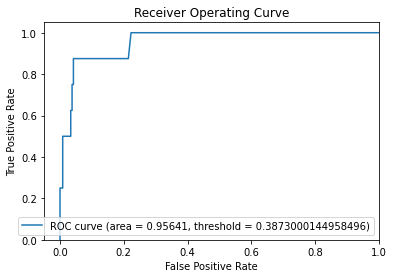

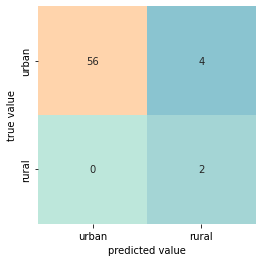

In [40]:
SMOTE_xgb = XGBClassifier(random_state = 112, n_estimators = 68, eta = 0.1, gamma = 0.1, max_depth = 6, reg_alpha = 1, objective = 'reg:logistic')

print_scores(SMOTE_xgb, CV = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5, random_state = 112), cv_score = 'all', smote = True)

print_roc(SMOTE_xgb, smote = True)
RUconfusion(SMOTE_xgb, smote = True)

NOTE: Model scores are relatively similar before & after hyperparamater tuning.


### Random forest (using balanced class weights)

In [43]:
### grid search initializer

CV = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 112)

In [45]:
# Preliminary grid search (searches 10x5Xx5 = 1000 sets of random values)

pipeline = Pipeline(steps = [['scaler', StandardScaler()], 
                             ['classifier', RandomForestClassifier(class_weight = 'balanced', random_state = 112)]])

grid = {'classifier__n_estimators': list(np.arange(10, 511, 50)), # no. different trees (probably should not < no. instances)
        'classifier__max_depth': list(np.arange(1, 52, 10)),      # no. levels in each tree (probably should not > no. features)
        'classifier__min_samples_leaf': list(np.arange(1, 8, 2)), # how many individuals needed in a node after splitting
        'classifier__min_samples_split': list(np.arange(2, 11, 2))} # how many individuals needed in a node to be able to split it
                                                        # (note 2 is the smallest permissible value)

prelim_grid_search = GridSearchCV(estimator = pipeline, param_grid = grid, scoring ='roc_auc', cv = CV, n_jobs = -1)
prelim_grid_search.fit(X, y)

prelim_grid_search.best_params_

{'classifier__max_depth': 11,
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 110}

In [46]:
### Final search (searches for 5x10x3x2x3 = 900 sets of values within a range around values from preliminary grid search)

grid = {'classifier__n_estimators': list(np.arange(95, 136, 10)),
        'classifier__max_depth': list(np.arange(6, 16, 1)),
        'classifier__min_samples_leaf': list(np.arange(2, 5, 1)),
        'classifier__min_samples_split': list(np.arange(2, 4, 1)),
        'classifier__max_features': ('sqrt', 'log2', None)}  

grid_search = GridSearchCV(estimator = pipeline, param_grid = grid, scoring = 'roc_auc', cv = CV, n_jobs = -1)
grid_search.fit(X, y)

grid_search.best_params_

{'classifier__max_depth': 5,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 115}

The final, best parameters for a balanced-rf model were determined to be:
- 'classifier__max_depth': 5
- 'classifier__max_features': 'sqrt' (default)
- 'classifier__min_samples_leaf': 3,
- 'classifier__min_samples_split': 2 (default)
- 'classifier__n_estimators': 115

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Cross-Validation Scores using RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=3,
                       n_estimators=115, random_state=112)


,train,std (train),test,std (test)
,,,,
accuracy,0.983508,0.001370,0.955285,0.207100
roc_auc,0.996406,0.002229,0.932334,0.099282
precision,0.718571,0.080737,0.329167,0.265561
recall,1.000000,0.000000,0.400000,0.307794
balanced_accuracy,0.993138,0.002643,0.688270,0.154586


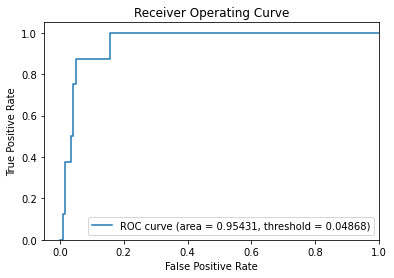

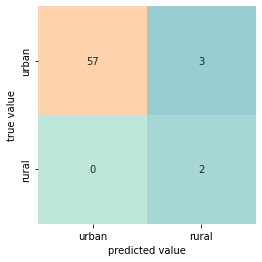

In [47]:
balanced_rf = RandomForestClassifier(class_weight = 'balanced', n_estimators = 115, max_depth = 5, min_samples_leaf = 3, random_state = 112)

print_scores(balanced_rf, CV = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5, random_state = 112), cv_score = 'all')
print_roc(balanced_rf, smote = False)
RUconfusion(balanced_rf, smote = False)

NOTE: The tuned hyperparameters MUCH improve this model (from predicting only the urban class to a fairly reasonable performance).

Also, note that the precision error is (largely) due to the small, imbalanced dataset (small number of rural participants): for non-ideal models, the model may sometimes predict no individuals as rural, thus leading to a division by zero error since precision is defined here as the number of true rural individuals out of all individuals classified as rural.

### Random forest (using SMOTE)

In [83]:
### grid search initializers

CV = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 112)

## need to lower no. neighbours used in smote, otherwise error in pipeline b/c there are only 6 rural??
## individuals in (training) set passed to pipeline, and thus only 4 in CV training set 

pipeline = Pipeline(steps = [['oversampler', SMOTE(random_state = 112)],
                             ['classifier', RandomForestClassifier(random_state = 112)]])

In [137]:
# Preliminary grid search (searches 10x5Xx5 = 1000 sets of random values)

grid = {'classifier__n_estimators': list(np.arange(10, 511, 50)), # no. different trees (probably should not < no. instances)
        'classifier__max_depth': list(np.arange(1, 52, 10)),      # no. levels in each tree (probably should not > no. features)
        'classifier__min_samples_leaf': list(np.arange(1, 8, 2)), # how many individuals needed in a node after splitting
        'classifier__min_samples_split': list(np.arange(2, 11, 2))} # how many individuals needed in a node to be able to split it
                                                                    # (note 2 is the smallest permissible value)

prelim_grid_search = GridSearchCV(estimator = pipeline, param_grid = grid, scoring='roc_auc', cv = CV, n_jobs = -1)
prelim_grid_search.fit(X, y)

prelim_grid_search.best_params_

{'classifier__max_depth': 11,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 6,
 'classifier__n_estimators': 110}

In [139]:
### Final search (searches for 6x15x2x3x3 = 1620 sets of values within a range around values from preliminary grid search)

grid = {'classifier__n_estimators': list(np.arange(80, 141, 10)),  ## from prelim grid search, 60 was better than 10/110
        'classifier__max_depth': list(np.arange(6, 17, 1)),         ## from prelim grid search, 11 was better than 1/21
        'classifier__min_samples_leaf': list(np.arange(1, 3, 1)),   ## from prelim grid search, 1 was better than 3
        'classifier__min_samples_split': list(np.arange(5, 8, 1)),  ## from prelim grid search, 2 was better than 4
       'classifier__max_features': ('sqrt', 'log2', None)}          ## max. number of features that a tree can consider when deciding on a split

grid_search = GridSearchCV(estimator = pipeline, param_grid = grid, scoring = 'roc_auc', cv = CV, n_jobs = -1)
grid_search.fit(X, y)

grid_search.best_params_

{'classifier__max_depth': 8,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 6,
 'classifier__n_estimators': 80}

The final, best parameters for a SMOTE-rf model were determined to be:
- 'n_estimators': 80
- 'min_samples_split': 6
- 'min_samples_leaf': 1 (default)
- 'max_depth': 8
- 'max_features': 'squrt' (default)

Cross-Validation Scores using RandomForestClassifier(max_depth=8, min_samples_split=6, n_estimators=80,
                       random_state=112)


,train,std (train),test,std (test)
,,,,
accuracy,0.996366,0.002054,0.943089,0.232144
roc_auc,1.000000,0.000000,0.909223,0.115818
precision,0.937500,0.081832,0.295833,0.226973
recall,1.000000,0.000000,0.425000,0.335410
balanced_accuracy,0.998740,0.001695,0.696561,0.170777


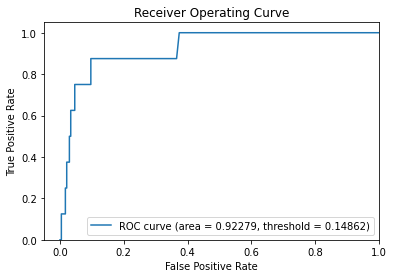

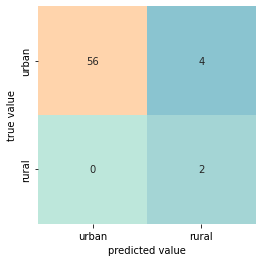

In [89]:
SMOTE_rf = RandomForestClassifier(n_estimators = 80, max_depth = 8, min_samples_split = 6, random_state = 112)

## fit rf model before or after print_scores?

print_scores(SMOTE_rf, CV = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5, random_state = 112), cv_score = 'all', smote = True)
print_roc(SMOTE_rf, smote = True)
RUconfusion(SMOTE_rf, smote = True)

As a final note, balanced versions of the SMOTE-lr and SMOTE-XGB models (using balanced class weights rather than SMOTE) were also investigated, but were found to have little difference between their counterparts using SMOTE.